# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

### **Q1: Mini Data Pre-Process**
First I wanted to clean up the data to get rid of missing values, separate the East and West coast into separate data frames that I could compare them, and I also created variables for the columns we would be comparing

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

tidal = pd.read_csv('/Users/delre/assignment-5/data/tidal_wetland_estuaries.csv')

tidaldata = tidal.replace(-9999, np.NaN)
missing = tidaldata.isnull()
#print(tidaldata)
#print(tidaldata[missing])

ec_soil = tidaldata.loc[tidaldata['coast']=='EAST',:].reset_index(drop=True)
wc_soil = tidaldata.loc[tidaldata['coast']=='WEST',:].reset_index(drop=True)

#print(wc_soil)
#print(ec_soil)

ec_soc_density = ec_soil['soc_density']
wc_soc_density = wc_soil['soc_density']

print(ec_soc_density)
print(wc_soc_density)

0     0.087
1     0.084
2     0.051
3     0.095
4     0.084
5     0.085
6     0.070
7     0.096
8     0.076
9     0.067
10    0.085
11    0.063
12    0.074
13    0.060
14    0.073
15    0.077
16    0.065
17    0.073
18    0.076
19    0.070
20    0.086
21    0.070
22    0.037
23    0.052
24    0.042
25    0.077
26    0.094
27    0.109
28    0.098
29    0.089
30    0.081
31    0.068
32    0.099
33    0.091
34    0.085
35    0.075
36    0.089
37    0.064
38    0.052
39    0.049
40    0.004
41    0.100
42    0.107
43    0.076
44    0.095
45    0.108
46    0.074
47    0.120
48    0.110
49    0.096
50    0.044
51    0.082
Name: soc_density, dtype: float64
0     0.014
1     0.023
2     0.007
3     0.004
4     0.002
5     0.046
6     0.017
7     0.012
8     0.080
9     0.034
10    0.024
11    0.039
12    0.041
13    0.031
14    0.036
15    0.048
16    0.055
17    0.048
18    0.052
19    0.052
20    0.044
21    0.044
22    0.055
23    0.054
24    0.050
25    0.034
26    0.051
27    0.053
28    

### **Q1: Checking for Normal Data**
I made some histograms to see if the data was normally distributed before running my tests since T-tests assume normal data

0.07757692307692311 is the mean value for East Coast Soil Density
0.077 is the median value for East Coast soil density


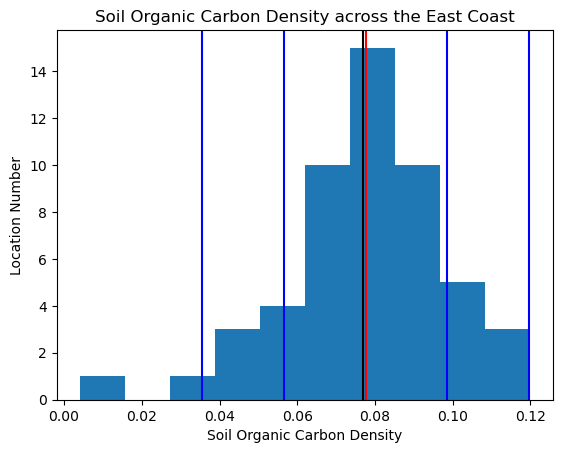

This histogram shows the east coast soil density data is normally distributed
The mean and median are about equal and the data is distributed about equally around the mean



In [35]:
ec_mean_soc_density = ec_soc_density.mean()
print(ec_mean_soc_density, 'is the mean value for East Coast Soil Density')

ec_median_soc_density = ec_soc_density.median()
print(ec_median_soc_density, 'is the median value for East Coast soil density')

ec_std_soc_density = np.std(ec_soc_density)

plt.hist(ec_soc_density)
plt.title('Soil Organic Carbon Density across the East Coast')
plt.xlabel('Soil Organic Carbon Density')
plt.ylabel('Location Number')
plt.axvline(x=ec_mean_soc_density, color="red")
plt.axvline(x=ec_median_soc_density, color="black")
plt.axvline(x=ec_mean_soc_density-ec_std_soc_density, color="blue")
plt.axvline(x=ec_mean_soc_density+ec_std_soc_density, color="blue")
plt.axvline(x=ec_mean_soc_density-2*ec_std_soc_density, color="blue")
plt.axvline(x=ec_mean_soc_density+2*ec_std_soc_density, color="blue")
plt.show()
print('This histogram shows the east coast soil density data is normally distributed')
print('The mean and median are about equal and the data is distributed about equally around the mean')
print("")

0.03779310344827588 is the mean value for West Coast Soil Density
0.044 is the median value for West Coast soil density


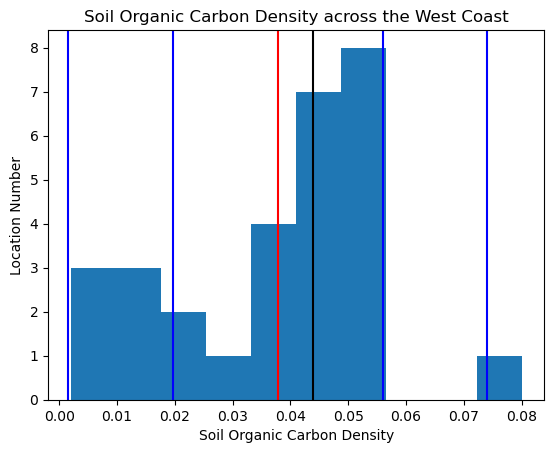

This histogram shows the West coast soil density data is normally distributed


In [36]:
wc_mean_soc_density = wc_soc_density.mean()
print(wc_mean_soc_density, 'is the mean value for West Coast Soil Density')

wc_median_soc_density = wc_soc_density.median()
print(wc_median_soc_density, 'is the median value for West Coast soil density')

wc_std_soc_density = np.std(wc_soc_density)

plt.hist(wc_soc_density)
plt.title('Soil Organic Carbon Density across the West Coast')
plt.xlabel('Soil Organic Carbon Density')
plt.ylabel('Location Number')
plt.axvline(x=wc_mean_soc_density, color="red")
plt.axvline(x=wc_median_soc_density, color="black")
plt.axvline(x=wc_mean_soc_density-wc_std_soc_density, color="blue")
plt.axvline(x=wc_mean_soc_density+wc_std_soc_density, color="blue")
plt.axvline(x=wc_mean_soc_density-2*wc_std_soc_density, color="blue")
plt.axvline(x=wc_mean_soc_density+2*wc_std_soc_density, color="blue")
plt.show()
print('This histogram shows the West coast soil density data is normally distributed')

While the West Coast Soil data does not have a nice bell shape like the East Coast data, it is still centralized around the median, which is close to the mean. About 2/3 of the data is within one standard deviation of the mean and about 95% of data is within two standard deviations of the mean.

### **Q1: Comparing datasets**

The next step in determining the appropriate T-test was to check whether both datasets had equal amounts of information:

In [37]:
print(ec_soc_density.shape)
print(wc_soc_density.shape)

print('A paired T-Test is impossible because each sample has a different amount of data')

(52,)
(29,)
A paired T-Test is impossible because each sample has a different amount of data


### **Q1: T-Test**
The hypothesis that soil organic carbon density is **larger** in the east coast than the west coast compares two different groups of data -- one representing soil collected on the east coast, and one on the other side of the country on the west coast.

**A 2-sample T test is the appropriate way to test this hypothesis. A 2-sample T test will compare the mean organic carbon density of soil on the two separate coasts.** 

A 1-sample T test would not make sense because East and West coast data are different samples; a paired T test would be impossible because the samples are different sizes, and it would not make sense because we are not trying to compare two variables for the same sample of data

In [38]:
from scipy.stats import ttest_ind

ttest_ind(ec_soc_density,wc_soc_density, alternative='greater',equal_var=True)

Ttest_indResult(statistic=8.45031778669312, pvalue=5.765284478012742e-13)

### **Q1: Interpreting the Results**
**The t-test supports the hypothesis that soil organic carbon density is larger in the East coast than the West coast.**

The p value is tiny (negative 13 exponent) -- far less than the .05 necessary to reject the null hypothesis (which assumes that soil organic carbon density is not larger in the East coast than the West coast).

When the t-value ('statistic') is close to 0, that indicates there is little difference between the means of the two samples being compared. In these cases, the null hypothesis (which assumes that the means of the two samples are equal) cannot be rejected. However in this case, the t-value ('statistic') is relatively high (8), meaning that the two samples have a large difference between their mean relative to their group variances, and by extention, granting greater confidence in the test results.

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

In [43]:
from utils import Linear_Reg_Diagnostic # do not change!
import statsmodels.formula.api as smf

tidal = pd.read_csv('/Users/delre/assignment-5/data/tidal_wetland_estuaries.csv')
tidaldata = tidal.replace(-9999, np.NaN)

ocean_model = smf.ols(formula='ocean_salinity_mean ~ mean_precip + estu_longintude + ocean_sst_mean',data=tidaldata).fit()
ocean_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ocean_salinity_mean   R-squared:                       0.834
Model:                             OLS   Adj. R-squared:                  0.829
Method:                  Least Squares   F-statistic:                     183.6
Date:                 Sun, 07 May 2023   Prob (F-statistic):           1.15e-42
Time:                         17:40:02   Log-Likelihood:                -115.16
No. Observations:                  114   AIC:                             238.3
Df Residuals:                      110   BIC:                             249.3
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          32.2576      0.386     83.553      0.000      31.492      33.023
mean_precip        -0.0009      0.000     -6.351      0.000      -0.001      -0.001
estu_longintude     0.0143      0.003      4.348      0.000       0.008       0.021
ocean_sst_mean      0.2086      0.010     20.656      0.000       0.189       0.229
==============================================================================
Omnibus:                       12.247   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.941
Skew:                          -0.726   Prob(JB):                      0.00155
Kurtosis:                       3.784   Cond. No.                     8.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)